<a href="https://colab.research.google.com/github/BenYavor/MA_GAN/blob/master/MA_GAN_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install tensorflow==2.0.0-rc0
!pip install -q pyyaml h5py
#!pip install -q tf_nightly
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt   
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
tf.__version__
from tensorflow import keras
import time

## System funktionsweise Allgemeine Daten

#### Rauschen
genarats-> **shape**: batch_size * number_of_real_channels_uses_per_message \\
and does a average power normalization


#### Generator
Eingang: (2*n,32)  ; Ausgang: (32,n)   \\
Loss-Function:

#### Discriminator
Eingang: (2*n,32)  ; Ausgang: (32,1)  \\
Loss-Function:


#### Training


###Systemparameter
$k$ - die Anzhal der bits \\
$M$ - Anzahl der unterschiedlichen Nachrichten \\
$n$ - channel uses **What is meant by that??** \\
$N$ - Länge des Rauschvektors

In [0]:
k = 4       # Number of information bits per message, i.e., M=2**k
M = 2**k
n = 2       # Number of real channel uses per message
seed = 2    # Seed RNG reproduce identical results
D_nb_weights = 32
G_nb_weights = 32


batch_size = 100


x = tf.random.normal((batch_size,n))    #randomly sample input data ("fake" AE messages)
x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x))) #Average power normalization (not required if standard normal distribution is used )

## Generator Model

In [33]:


#def generator(x):
    # Concatenate z and y
#    G_n = tf.random.normal([tf.shape(x)[0],n],dtype=tf.float32)  #create noise directly within the generator  
#    inputs = tf.concat(values=[x, G_n], axis=1)
    #dense NN
#    G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
#    G_h2 = tf.nn.relu(tf.matmul(G_h1, G_W2) + G_b2)
#    G_lin = tf.matmul(G_h2, G_W3) + G_b3
    #G_prob = tf.nn.sigmoid(G_lin)
#    return G_lin

def generator_noise(input):
  G_n = tf.random.normal([tf.shape(input)[0],n],dtype=tf.float32)  #create noise directly within the generator  
  inputs = tf.concat(values=[input, G_n], axis=1)
  return inputs
    
def generator(x = tf.keras.Input(shape=(batch_size,n)),training = False):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Lambda(generator_noise))
  model.add(tf.keras.layers.Dense(32,use_bias=True, activation='relu'))#, input_shape=(2*n,))
  model.add(tf.keras.layers.Dense(32,use_bias=True,  activation='relu'))
  model.add(tf.keras.layers.Dense(n,use_bias=False, activation='sigmoid'))
  return model

generator= generator()
test = generator(x)
print(test)

tf.Tensor(
[[0.46109313 0.46139178]
 [0.5640976  0.49818423]
 [0.5384959  0.4722582 ]
 [0.5291493  0.5304533 ]
 [0.5085808  0.49630043]
 [0.5194655  0.52837825]
 [0.4086768  0.36144972]
 [0.5274147  0.52902603]
 [0.5280123  0.51495135]
 [0.59059936 0.55196995]
 [0.527848   0.5045744 ]
 [0.5594921  0.45417446]
 [0.53903466 0.41238734]
 [0.4797062  0.4262348 ]
 [0.53213054 0.41969734]
 [0.49859303 0.4299028 ]
 [0.50411695 0.5132177 ]
 [0.42387855 0.444058  ]
 [0.5300688  0.44966546]
 [0.5075823  0.513632  ]
 [0.5743154  0.5389375 ]
 [0.4145344  0.3723564 ]
 [0.4776653  0.52187365]
 [0.47606838 0.44934514]
 [0.4993501  0.50872827]
 [0.48829684 0.4649793 ]
 [0.5145876  0.51299226]
 [0.56271076 0.39320835]
 [0.38247877 0.36551905]
 [0.49693912 0.49500066]
 [0.5765868  0.48699763]
 [0.5301109  0.43966848]
 [0.49013013 0.5024938 ]
 [0.469551   0.37174052]
 [0.44433272 0.4963764 ]
 [0.49519277 0.42926928]
 [0.51143724 0.46367413]
 [0.5404545  0.5010194 ]
 [0.5759426  0.5009629 ]
 [0.5417402  0

### Help Functions

In [0]:
def EbNo2Sigma(ebnodb):
    '''Convert Eb/No in dB to noise standard deviation'''
    ebno = 10**(ebnodb/10)
    return 1/np.sqrt(2*(2*k/n)*ebno)

#numpy version of kl divergence
def kl_divergence_np(p, q):
    #use "Laplace correction" w to avoid zero and inf
    w=1e-5
    p = p + w
    q = q + w
    return np.sum(p * np.log(p / q))

#tensorflow version of kl divergence
def kl_divergence_tf(p, q):
    #use "Laplace correction" w to avoid zero and inf
    w = 1e-5
    p = p + w
    q = q + w
    return tf.reduce_sum(p * tf.log(p / q))

## Channels as Black-Box

In [0]:
train_SNR_dB = 6
noise_std = EbNo2Sigma(train_SNR_dB)

def real_channel(x):
    # Black-box Channel
    #AWGN
    return x + tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)

    #Rayleigh
    #return x + tf.sqrt(tf.square(tf.random_normal(tf.shape(x), mean=0.0, stddev=noise_std)) + tf.square(tf.random_normal(tf.shape(x), mean=0.0, stddev=noise_std)))
    
    #Uniform U(-3;3)    
    #return x + tf.random_uniform(tf.shape(x), minval=-2, maxval=2)

    


## Discriminator
Model definition and creating discriminator


In [0]:
def concc(y,x):  
  inputs = tf.concat(values=[y,x], axis=1)
  return inputs

def get_discriminator():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(32,use_bias=True, activation='relu',input_shape=((2*n,))))
  model.add(tf.keras.layers.Dense(16,use_bias=True,  activation='relu'))
  model.add(tf.keras.layers.Dense(1,use_bias=False,activation='sigmoid'))
  return model
discriminator = get_discriminator()

#def discriminator(y,x):
#    # Concatenate x and y
#    inputs = tf.concat(values=[y,x], axis=1)
#    #dense NN
#    D_h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)
#    D_logit = tf.matmul(D_h1, D_W2) + D_b2
#    D_prob = tf.nn.sigmoid(D_logit)
#    return D_prob, D_logit

## Data Generation, überhaupt noch relevant??!!

## discriminator desicion????


In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Define Loss
strongly inspiered by: \\
https://www.tensorflow.org/beta/tutorials/generative/dcgan?hl=en

## defining Loss. TODO:
compile the Model with the right loss functions

In [38]:
x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)    #randomly sample input data ("fake" AE messages)
x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
real_training_data = tf.concat(values=[real_channel(x), x], axis=1)  
fake_training_data = tf.concat(values=[generator(x, training =True),x], axis=-1)

print(real_training_data.shape,fake_training_data.shape)
real_output = discriminator(real_training_data)
fake_output = discriminator(fake_training_data)
print(fake_output)
#print(real_output, fake_output)

(100, 4) (100, 4)
tf.Tensor(
[[0.43171448]
 [0.42564246]
 [0.45315316]
 [0.44333774]
 [0.35031766]
 [0.43838906]
 [0.42375702]
 [0.4522534 ]
 [0.38115877]
 [0.4310927 ]
 [0.45088425]
 [0.4374511 ]
 [0.46071082]
 [0.4136397 ]
 [0.37760836]
 [0.42867538]
 [0.3850702 ]
 [0.45799187]
 [0.37391722]
 [0.4475627 ]
 [0.4374724 ]
 [0.45497382]
 [0.4315776 ]
 [0.41336933]
 [0.44209206]
 [0.45354265]
 [0.39026222]
 [0.44616538]
 [0.3883156 ]
 [0.45519927]
 [0.45055714]
 [0.42013437]
 [0.4420087 ]
 [0.4186934 ]
 [0.4581687 ]
 [0.44158956]
 [0.44933274]
 [0.4538879 ]
 [0.3458306 ]
 [0.41672224]
 [0.41200513]
 [0.44958013]
 [0.44412896]
 [0.40644142]
 [0.41699827]
 [0.4511185 ]
 [0.44707194]
 [0.4122451 ]
 [0.4548698 ]
 [0.42626217]
 [0.4538915 ]
 [0.43298376]
 [0.43728915]
 [0.44156045]
 [0.44150192]
 [0.45437476]
 [0.43233162]
 [0.4468142 ]
 [0.41526642]
 [0.4418656 ]
 [0.4351177 ]
 [0.43062174]
 [0.3698519 ]
 [0.43615752]
 [0.42826578]
 [0.45215383]
 [0.39718315]
 [0.42283887]
 [0.40891093]
 [0.4

In [0]:
def discriminator_loss(real_output, fake_output):
  loss= -tf.reduce_mean(tf.math.log(real_output) + tf.math.log(1. - fake_output))   #use "-" sign to minimize rather than maximize loss
  return loss
  
def generator_loss(fake_output, generator):
  loss = -tf.reduce_mean(tf.math.log(fake_output))
  return loss

generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

# Evaluation with Histogram

In [0]:
def generate_evaluation_data(batch_size=100):
  x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)    #randomly sample input data ("fake" AE messages)
  x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x))) #Average power normalization (not required if standard normal distribution is used )
  #G_n = tf.random.normal([tf.shape(x)[0],n],dtype=tf.float32) 
  #inputs = tf.concat(values=[x, G_n], axis=1)
  fake_eval_data = tf.concat(values=[generator(x), x], axis=1)
  real_eval_data = tf.concat(values=[real_channel(x), x], axis=1) #tf.concat(values=[real_channel(x),x], axis=1)
  inputs = x
  return  real_eval_data, fake_eval_data, inputs 



def get_evaluation_data(evaluation_per_epochs):
  real_eval_data = []
  fake_eval_data  = []
  inputs = []
  for i in range(evaluation_per_epochs):
    data = generate_evaluation_data()
    real_eval_data.append(data[0])
    fake_eval_data.append(data[1])
    inputs.append(data[2])
  return real_eval_data, fake_eval_data, inputs


def test_eval(real_eval_data,fake_eval_data,inputs):
  hist_range = 2
  
  inputs_ = tf.concat(values=[inputs, inputs],  axis=-1)
  
  fake_output_hist = np.mean(fake_eval_data,axis=1)  # Changed from 0 to 1
  real_output_hist = np.mean(real_eval_data,axis=1)
  inputs_hist = np.mean(inputs_,axis=1)
    
  fake_output_hist1 = np.reshape( fake_output_hist,[-1,])
  real_output_hist1 = np.reshape( real_output_hist,[-1,])
    
  plt.hist(fake_output_hist1,bins=100,range=(-hist_range,hist_range),density=True,histtype='step')
  plt.hist(real_output_hist1,bins=100,range=(-hist_range,hist_range),density=True,histtype='step')    
  plt.title("noise distribution")
  plt.legend(["generator", "target"])
  plt.show()
  
  fake_noise = np.reshape( fake_output_hist - inputs_hist,[-1,])
  real_noise = np.reshape( real_output_hist - inputs_hist,[-1,])
   
  plt.hist(fake_noise,bins=100,range=(-hist_range,hist_range),density=True,histtype='step')
  plt.hist(real_noise,bins=100,range=(-hist_range,hist_range),density=True,histtype='step')    
  plt.title("noise distribution after subtracting Inpus_noise")
  plt.legend(["generator", "target"])
  plt.show()
    
    #print("decision for fake data was %d: and for real data was %d:" % (decision_fake, decision_real))

### Define the training loop

In [0]:
epochs = 20
steps_per_epoches = 50
batch_size = 100

evaluation_per_epochs = 100

noise_dim = n        #noch ändern wenn ich noise ändere
num_examples_to_generate = 16




In [0]:
def train(epochs, steps_per_epoches , batch_size, generator, discriminator):
  start = time.time()
  counter = 0
  epoch = 0
  for epoch in range(epochs):
    start = time.time()
    #print(massege_batch)
    counter += 1
    train_step(epoch, steps_per_epoches , batch_size, generator, discriminator) 
    if counter%5 == 0:
      print("counter %d:" % (counter))
    if counter%5 == 0:
      real_eval_data, fake_eval_data, inputs = get_evaluation_data(evaluation_per_epochs)
      test_eval(real_eval_data, fake_eval_data, inputs)
    print ('Time for epoch {} is {} sec,'.format(epoch + 1, time.time()-start))
    
    
       
  checkpoint_path = "training_1/cp.ckpt"
  checkpoint_dir = os.path.dirname(checkpoint_path)

  cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=False,
                                                 verbose=1)    

  print ('Time for the training is {} sec,'.format( time.time()-start))
    
   

  # Generate after the final epoch
    


The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [0]:
#@tf.function
#def train_step(massege_batch,counter):
#    x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)    #randomly sample input data ("fake" AE messages)
#    x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
    #G_n = tf.random.normal([tf.shape(x)[0],n],dtype=tf.float32) 
    #inputs = tf.concat(values=[x, G_n], axis=1)
#    real_training_data = tf.concat(values=[real_channel(x), x], axis=1)  #tf.concat(values=[real_channel(x),x], axis=1)


 #   with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:           #tapes the gradient of the generaor an the discriminator
  #    fake_training_data = tf.concat(values=[generator(x, training =True),x], axis=1)
      
 #     real_output = discriminator(real_training_data, training=True)
 #     fake_output = discriminator(fake_training_data, training=True)

 #     disc_loss = -tf.reduce_mean(tf.math.log(real_output) + tf.math.log(1. - fake_output))   #use "-" sign to minimize rather than maximize loss
 #     gen_loss = -tf.reduce_mean(tf.math.log(fake_output))

 #     gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
 #     gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  #    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  #    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    


In [0]:
@tf.function

def train_step(epoch, steps_per_epoches , batch_size, generator, discriminator):

    
  for j in range(steps_per_epoches):
    x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)    #randomly sample input data ("fake" AE messages)
    x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
    real_training_data = tf.concat(values=[real_channel(x), x], axis=1)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      fake_training_data = tf.concat(values=[generator(x, training =True),x], axis=1)
      real_output = discriminator(real_training_data, training=True)
      fake_output = discriminator(fake_training_data, training=True)
      disc_loss = -tf.reduce_mean(tf.math.log(real_output) + tf.math.log(1. - fake_output))   #use "-" sign to minimize rather than maximize loss
      gen_loss = -tf.reduce_mean(tf.math.log(fake_output))
      #print(disc_loss, gen_loss)
          
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
      
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


## Train the model

Time for epoch 1 is 19.56308078765869 sec,
Time for epoch 2 is 19.05117106437683 sec,
Time for epoch 3 is 20.546721696853638 sec,
Time for epoch 4 is 20.107983112335205 sec,
counter 5:


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


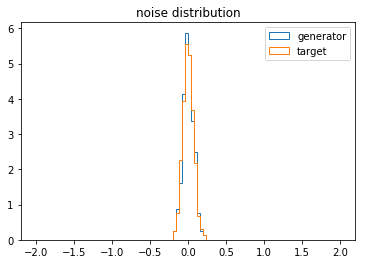

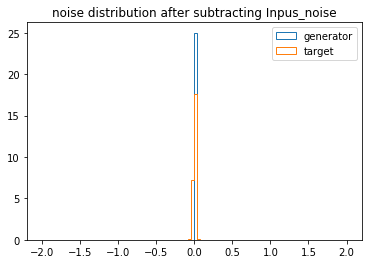

Time for epoch 5 is 31.850390672683716 sec,
Time for epoch 6 is 21.103191375732422 sec,
Time for epoch 7 is 19.096497535705566 sec,
Time for epoch 8 is 21.37209677696228 sec,
Time for epoch 9 is 21.014540195465088 sec,
counter 10:


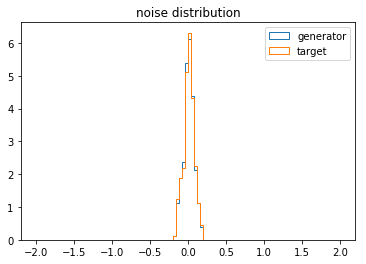

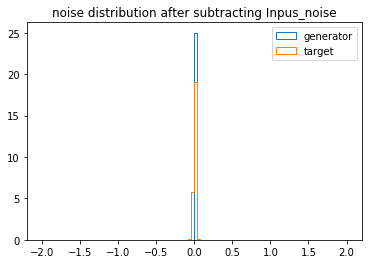

Time for epoch 10 is 29.906044006347656 sec,
Time for epoch 11 is 18.954143285751343 sec,
Time for epoch 12 is 22.028929710388184 sec,
Time for epoch 13 is 18.646919012069702 sec,
Time for epoch 14 is 21.99963092803955 sec,
counter 15:


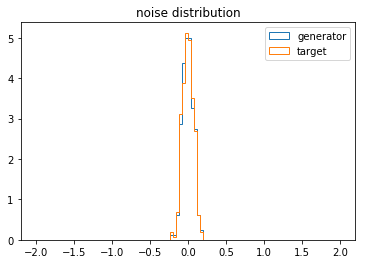

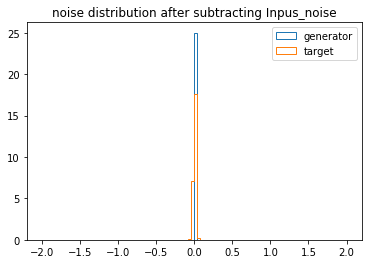

Time for epoch 15 is 29.77204132080078 sec,
Time for epoch 16 is 18.575794219970703 sec,
Time for epoch 17 is 18.340243577957153 sec,
Time for epoch 18 is 22.940725088119507 sec,
Time for epoch 19 is 18.477978229522705 sec,
counter 20:


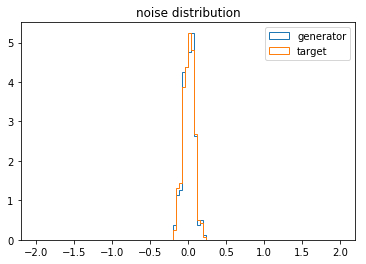

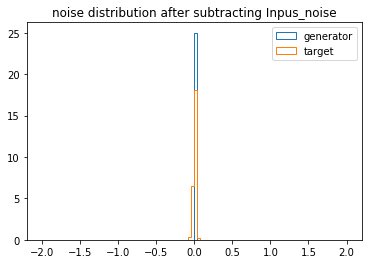

Time for epoch 20 is 29.545398235321045 sec,
Time for the training is 29.545790672302246 sec,
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            multiple                  0         
_________________________________________________________________
dense_12 (Dense)             multiple                  160       
_________________________________________________________________
dense_13 (Dense)             multiple                  1056      
_________________________________________________________________
dense_14 (Dense)             multiple                  64        
Total params: 1,280
Trainable params: 1,280
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
de

In [63]:
%%time
train(epochs, steps_per_epoches , batch_size, generator, discriminator)

generator.summary()
discriminator.summary()

### Restore the latest checkpoint.

In [0]:
#x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)    #randomly sample input data ("fake" AE messages)
#x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
#discriminator = keras.models.load_model('my_discriminator.h5')
#generator = keras.models.load_model('my_generator.h5')
#generator1 = generator(x)
#generator1.fit(x, real_channel(x),  epochs = 10,
#          validation_data = (x,real_channel(x)),
#          callbacks = [cp_callback])

#real_eval_data, fake_eval_data, inputs = get_evaluation_data(evaluation_per_epochs)
#test_eval(real_eval_data, fake_eval_data, inputs)

In [74]:
x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)    #randomly sample input data ("fake" AE messages)
x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
#print(x)
real_c = real_channel(x)
fake_c = generator(x)

print(fake_c)


tf.Tensor(
[[nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]

## AE
Die Idee sollte sein das Training auf den encoder und decoder einzuschränken. Jedoch soll **end-to-end** trainiert werden, hierfür sollte vllt eine art Funktion eingesetzt werden, welche über die GAN's Layer zurück geht.
Muss ich hierfür die Layer nochmals einzeln definieren?


***Vermutung: Der Ausgang hat die 8fache dimension des Eingangs-> daher nur 1/8 richtig oder 7/8 richtig*** \\
**zu klären: was passiert in meinem AE dass sie dei dimension ver8-facht von (1000,8) zu (8000,n)**
**Kontrollieren was der output von meinem GAN ist**
**Add complexity for higher rubustness**




In [66]:


def get_encoder():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=[M]))
  model.add(tf.keras.layers.Dense(M,use_bias=True, activation='relu'))
  model.add(tf.keras.layers.Dense(M,use_bias=True, activation='relu'))
  model.add(tf.keras.layers.Dense(n,use_bias=False, activation=None))
  model.add(tf.keras.layers.Lambda(lambda x : tf.divide(x, tf.sqrt(2*tf.reduce_mean(tf.square(x))))))
  return model

def get_decoder():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=[n]))
  model.add(tf.keras.layers.Dense(n,use_bias=True, activation='relu'))
  model.add(tf.keras.layers.Dense(M,use_bias=True, activation='relu'))
  model.add(tf.keras.layers.Dense(M,use_bias=False, activation='softmax'))
  return model

encoder = get_encoder()
decoder = get_decoder()

encoder.summary()
generator.summary()
decoder.summary()
   
def get_AE(encoder, generator, decoder):
  AE_model = tf.keras.Sequential()
  AE_model.add(encoder)
  AE_model.add(tf.keras.layers.Lambda(generator))
  AE_model.add(decoder)
  return AE_model
          
    
def generate_data_vector(length):
  random_vector = tf.random.uniform(shape =(length,),minval=0,maxval=M, dtype=tf.dtypes.int32 ,seed=None,name=None)
  random_hot_one_vector = tf.one_hot(random_vector, depth=M,on_value=1, off_value=0,axis=-1)
  print(random_hot_one_vector.shape)
  return random_hot_one_vector

data, test_data = generate_data_vector(1000000), generate_data_vector(10000)
#print(data)

#model = Autoencoder()
AE = get_AE(encoder, generator, decoder)
AE.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history = AE.fit(data, data, batch_size=100,steps_per_epoch=1100, epochs=5)





  

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_31 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_32 (Dense)             (None, 2)                 32        
_________________________________________________________________
lambda_8 (Lambda)            (None, 2)                 0         
Total params: 576
Trainable params: 576
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            multiple                  0         
_________________________________

In [0]:
train_SNR_dB = 6

def analytic_channel(input): 
  #print(input.shape)
  return input + tf.random.normal(tf.shape(input), mean=0.0, stddev=noise_std)

def real_transmision(test_data):
  y = encoder(test_data)
  y = generator(y)
  y = decoder(y)
  return y
  #model = tf.keras.Sequential()
  #model.add(encoder)
  #model.add(tf.keras.layers.Lambda(generator))
  #model.add(tf.keras.layers.Lambda(real_channel))
  #model.add(decoder)
  #return model

def test_diff_eval(test_data, results):
  diff = []
  for i in range(tf.shape(test_data)[0]):
    diff.append(tf.math.subtract(test_data[i,:], results[i,:]))
  return diff
    
  
real_AE = real_transmision(test_data)
testTest = tf.dtypes.cast(real_AE + tf.constant(0.1,dtype=tf.float32,shape=tf.shape(real_AE)), tf.int32)

diff_test =  test_diff_eval(test_data, testTest) 
#t = tf.math.subtract(test_data[1,:], real_AE[1,:])





In [68]:
print(sum(diff_test))

tf.Tensor([601 619 618 658 615 656 620 652 645 625 569 594 632 639 637 620], shape=(16,), dtype=int32)


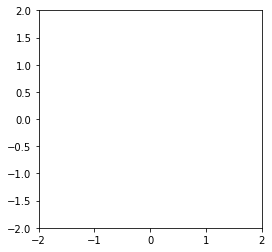

In [69]:
tes_data = np.eye(M, dtype = int)
coding= encoder.predict(tes_data)
fig = plt.figure(figsize=(4,4))
plt.plot(coding[:,0], coding[:,1],"b.")
plt.gca().set_ylim(-2,2)
plt.gca().set_xlim(-2,2)
plt.show()

## Trainingparameters

In [0]:
train_EbNodB = 6
val_EbNodB = train_EbNodB

training_params = [
    #batch_size, lr, ebnodb, iterations
    [100    , 0.001, train_EbNodB, 1000],
    [100    , 0.0001, train_EbNodB, 10000],
    [1000    , 0.0001, train_EbNodB, 10000]
]

validation_params = [
    #batch_size, ebnodb, val_steps 
    [100000, val_EbNodB, 100],
    [100000, val_EbNodB, 1000],
    [100000, val_EbNodB, 1000]
]

## Create and train model

In [23]:
model_file_baseline = 'models/ae_baseline_k_{}_n_{}'.format(k,n)

ae_baseline = AE(k,n,useGAN=False,seed=seed)
ae_baseline.train(training_params, validation_params)

ae_baseline.save(model_file_baseline)

TypeError: ignored